In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from pyens.models import Flywheel, OCV, EcmCell
from pyens.utilities import ivp
from pyens.simulations import Data, Current, Learner,Simulator
import os
import matplotlib.pyplot as plt

this example shows how to simulate battery terminal voltage based on 

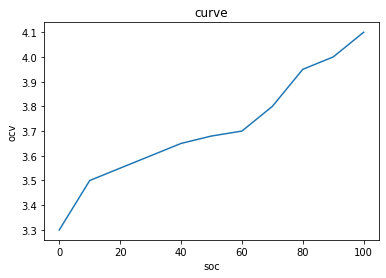

In [2]:
ocv = [3.3, 3.5, 3.55, 3.6, 3.65, 3.68, 3.70, 3.8, 3.95, 4.0, 4.1]
soc = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

/workspaces/pyens/.venv/lib/python3.10/site-packages/schemdraw/elements/elements.py:115: UserWarning: Duplicate direciton parameter in element: `right` replaced with `theta=0`
  warnings.warn(f"Duplicate direciton parameter in element: `{self._userparams['d']}` replaced with `theta={theta}`")


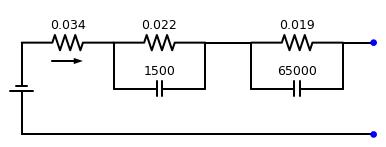

In [3]:
param = {
 "R0": 0.034,
 "R1": 0.022,
 "C1": 1500,
 "R2": 0.019,
 "C2": 65000,
 "CAP": 15,
 "ce": 0.96,
 "v_limits": [2.5, 4.5],
 "SOC_RANGE": [0.0, 100.0],
}

m1 = EcmCell(name="cell_model1", parameters=param, curve=c1)
m1.display()

In [4]:
dt = 0.1
CURR_EXCITATION = 7.5
HOUR = 3600.0
h_steps = [1.75, 0.25, 0.25, 0.25, 1, 1, 1]
current_steps = [
 -CURR_EXCITATION,
 -CURR_EXCITATION / 2,
 -CURR_EXCITATION / 4,
 -CURR_EXCITATION / 8,
 0.0,
 CURR_EXCITATION,
 0.0,
]

initial_soc = 0.0
t_steps = [value * HOUR for value in h_steps]
total_time = sum(t_steps)
samples = int(total_time / dt)

time_np = np.linspace(0.0, total_time, samples)
step_cur = Current(name="current1")

In [5]:
for t_step, current_step in zip(t_steps, current_steps):
 step_cur.add_step(current_step, int(t_step / dt))

data = {"time": time_np, "current": step_cur.current}
df = pd.DataFrame(data)
d1 = Data(name="current_excite", df=df)


In [6]:
s1 = Simulator(name="simulator1")
s1.attach(m1).attach(d1)

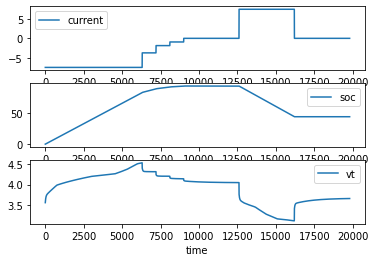

In [7]:
sol = s1.run(
    pair=("cell_model1", "current_excite"),
    x0=np.array([0, 0, initial_soc]),
    config={"solver_type": "adaptive", "solution_name": "sol1"},
)

sol.disp(["current", "soc", "vt"])